# Report Checkpoint

Brady Zhou, 
Raymond Zhao, 
and Lingpeng Meng

### Problem

A playing speaker is placed on a desk in a room. With a set of microphone arrays placed around the room, its location can be roughly triangulated given the resulting data collected by the arrays, processed using beamforming [1]. In our experiment, our 5 arrays each produce a 3D "vector" of arrival that tells the direction from which the array perceived the signal. From here, the goal becomes to transform this data from $\mathbb{R}^{15}$ to $\mathbb{R}^{3}$

There are several naive solutions here, but two stand out as particularly robust: PCA and linear mapping. PCA seems a natural fit; downsizing from $15 \to 3$ with no real interpretative significance on any particular variable. While surprisingly precise, PCA suffers from 2 large issues: PCA can't handle missing values and the arrays' data output can be inconsistent, and the final result is couched in the fitted PCA space, which is extremely difficult to map back to the real world.

Linear (or affine) mappings solve the issues of missing values and abstract spaces but still leave a little to be desired, since accuracy is then limited by the fact that it still only maps linear functions when clearly the underlying dynamics of a room are likely nonlinear. This in addition to the fact that they need to be very well calibrating on anchor points to work some things to be desired, so the aim then is to find models to address the problems above while minimizing tradeoffs in accuracy or practicality.

### Setup

In [2]:
import sys
sys.path.append('../src')
from Mapping import *
sys.path.append('../src/prediction')
from PCA import *
from nn import *

import pickle
import matplotlib
import matplotlib.pyplot as plt

In [5]:
V5 = pickle.load(open('../data/V5.p','rb'))
cp_list = V5["cp_list"]
active_L_table_slide_DOA = V5["active_L_table_slide_DOA"]
active_L_table_slide_matrix = V5["active_L_table_slide_matrix"]
active_long_table_slide_DOA = V5["active_long_table_slide_DOA"]
active_long_table_slide_matrix = V5["active_long_table_slide_matrix"]

### Plots

#### Feedforward Neural Net

In [7]:
cp_torch = [torch.from_numpy(cp) for cp in cp_list[:4]]
room_coords = [torch.from_numpy(np.array([i[0], i[1]])) for i in ROOM_COORDINATES[:4]]
X = cp_torch
y = room_coords

In [8]:
model = NeuralNet(input_size, hidden_size, output_size)
model = model.float()

model.train(X, y)
predictions = model.predict(active_L_table_slide_DOA)

C:\Users\kazzh\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([399, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kazzh\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([300, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kazzh\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([500, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

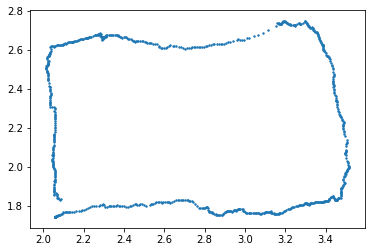

In [11]:
mapX = [x[0] for x in predictions]
mapy = [x[1] for x in predictions]
plt.scatter(mapX, mapy, s=2)

#### Support Vector Machine

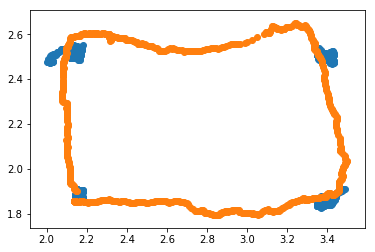

In [5]:
control_points = cp_list[:4]
coordinates = [np.array([i[0], i[1]]) for i in ROOM_COORDINATES[:4]]
X = np.vstack([c for c in cp_list[:4]])
y = np.vstack([np.full([p.shape[0], len(c)], c) for p, c in zip(control_points, coordinates)])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

regr = MultiOutputRegressor(SVR(kernel='rbf', C=1e3, gamma=0.1))
regr.fit(X, y)

plt.scatter(*regr.predict(X).T)
plt.scatter(*regr.predict(active_L_table_slide_DOA).T)

#### SVM compared with Random Forest

C:\Users\kazzh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kazzh\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\kazzh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\kazzh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

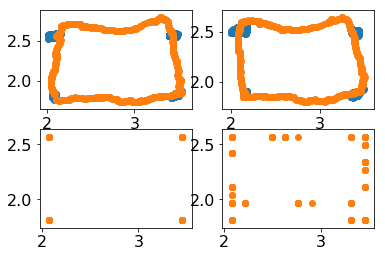

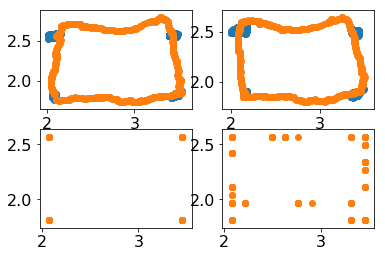

In [7]:
control_points = cp_list[:4]
coordinates = [np.array([i[0], i[1]]) for i in ROOM_COORDINATES[:4]]
X = np.vstack([c for c in cp_list[:4]])
y = np.vstack([np.full([p.shape[0], len(c)], c) for p, c in zip(control_points, coordinates)])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
models = {
	'linear regression': LinearRegression,
	'svr': SVR,
	'decision tree': DecisionTreeRegressor,
	'random forest': RandomForestRegressor
}
for m, ax in zip(models.items(), axes):
	model, model_name = m
	regr = MultiOutputRegressor(model())
	regr.fit(X, y)
	ax.scatter(*regr.predict(X).T)
	ax.scatter(*regr.predict(active_L_table_slide_DOA).T, label=model_name)
fig

### References

[1] P. Gerstoft, Y. Hu, M. J. Bianco, C. Patil, A. Alegre, Y. Freund, F. Grondin “Audio scene monitoring using redundant ad-hoc microphone array networks”

[2] M. Hahmann, E. Fernandez-Grande, H. Gunawan, P. Gerstoft “Sound Source Localization in 3D Using Ad-Hoc Distributed Microphone Arrays”

[3] B. Zhou, R. Zhao, L. Meng "Interpreting Microphone Arrays with Machine Learning Methods"